# RNA velocity comparison

Here we can compare the results of RNA velocity analysis ran on two different kinds of datasets. This dataset contains a subset of ~10K cells of the original adolescent mouse brain atlas from [Linnarson Lab](http://mousebrain.org/adolescent/) that has already been processesed

In [2]:
import scvelo as scv
import loompy as lp
import pandas as pd
import numpy as np
import umap
import scanpy
from matplotlib import pyplot as plt
import pickle
from matplotlib import colors

In [4]:
def save_object(obj, filename):
    with open(filename, 'wb') as output: 
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(file):
    with open(file, 'rb') as inF:
        obj = pickle.load(inF)
        return(obj)

In [34]:
scv.logging.print_version()
scv.settings.verbosity = 0  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.3 (python 3.8.8) on 2021-03-28 18:46.


## Preprocessing

In [5]:
adata = load_object('../data/objects/a4.mBA18.subset.pkl' )
adata

AnnData object with n_obs × n_vars = 6264 × 15
    obs: 'batch', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'labels', 'leiden', 'n_counts', 'n_genes', 'type'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'rank_velocity_genes', 'clusters_gradients_colors'
    obsm: 'X_umap'
    varm: 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

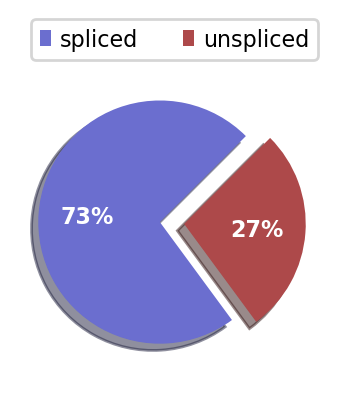

In [9]:
scv.pl.proportions(adata)

In [11]:
scv.pp.filter_and_normalize(adata,min_shared_counts=10,min_shared_cells=100,n_top_genes=2000)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

## Estimations

In [7]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.recover_latent_time(adata)
scv.tl.velocity_confidence(adata)
scv.tl.terminal_states(adata)
scv.tl.rank_velocity_genes(adata, groupby='labels',n_genes=500)

## Visualizations

### Velocities on embedding

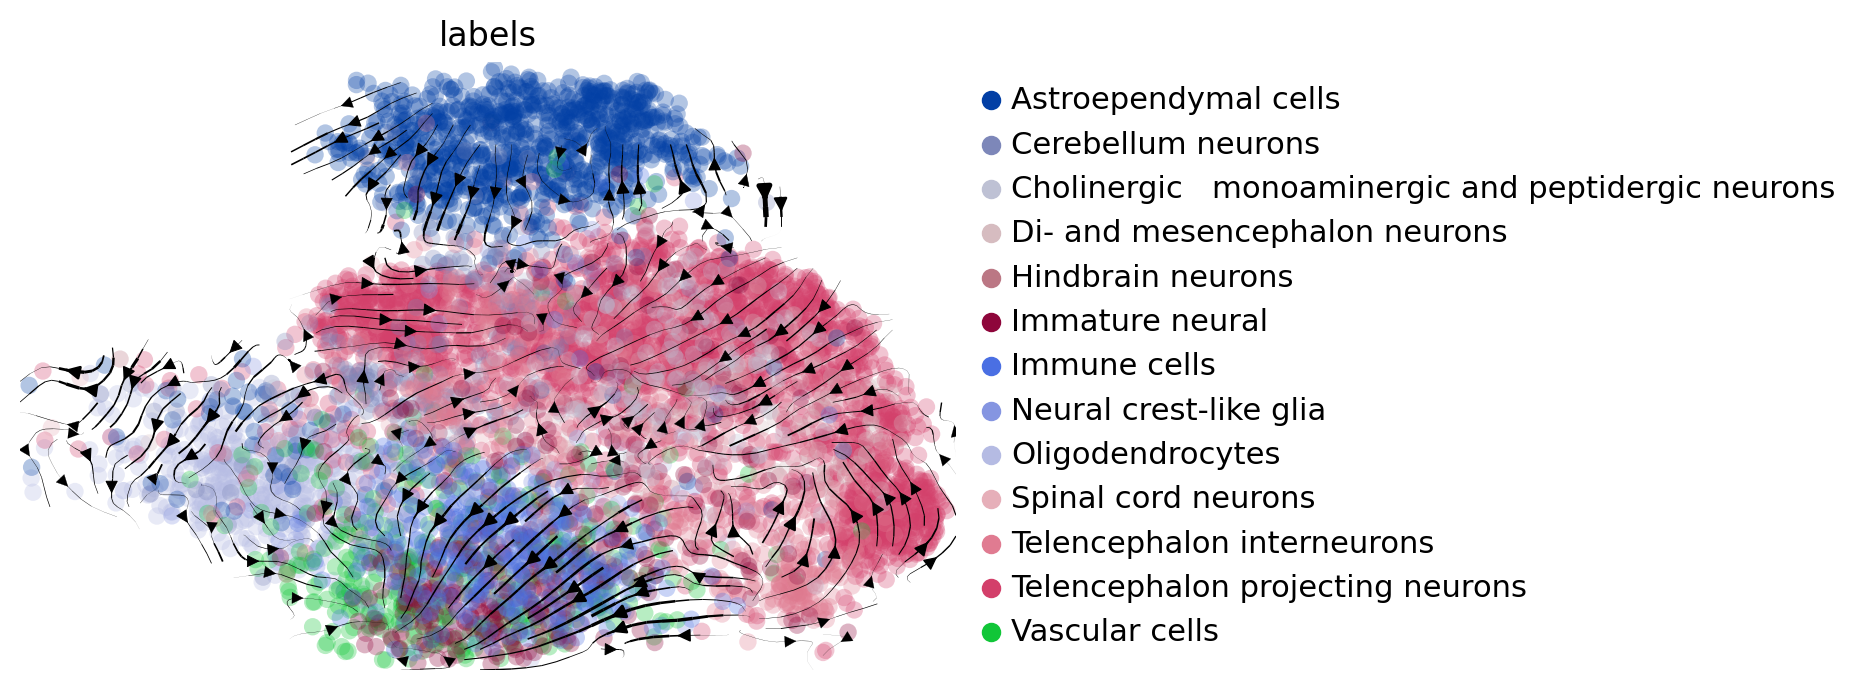

In [15]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='labels',legend_loc='right')

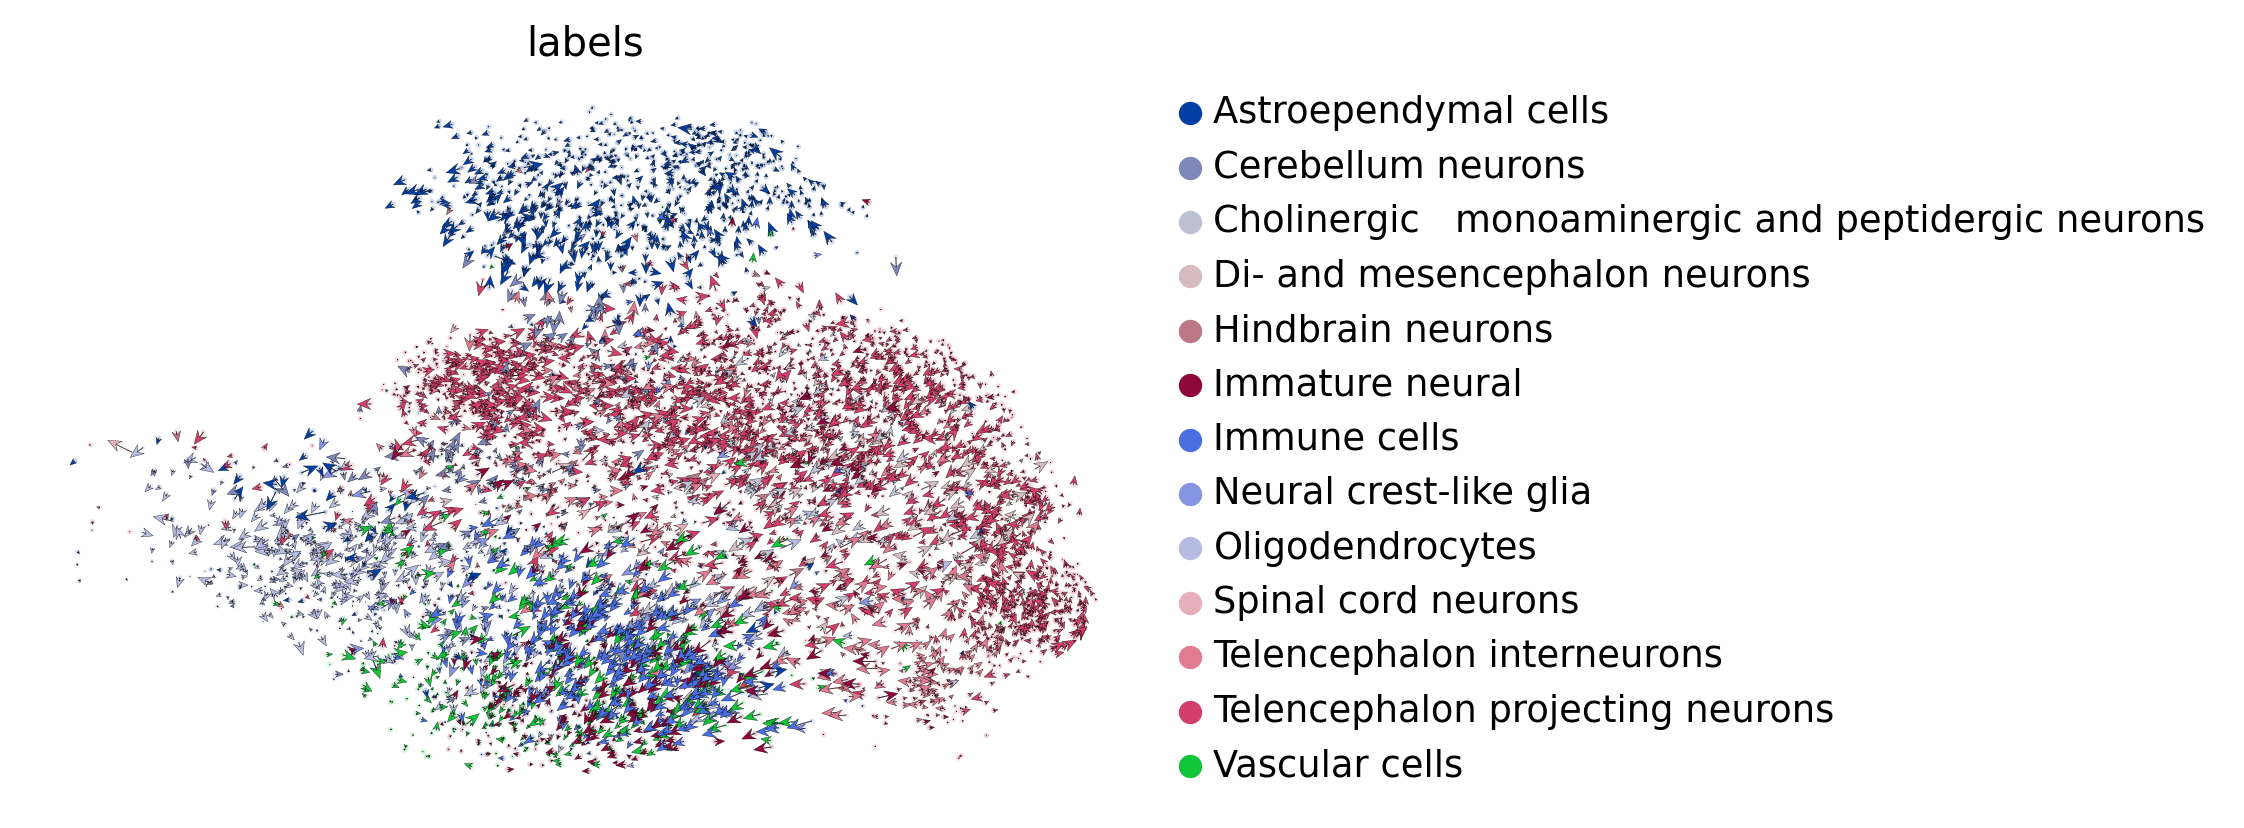

In [17]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120,color='labels',legend_loc='right')

### Velocity confidence

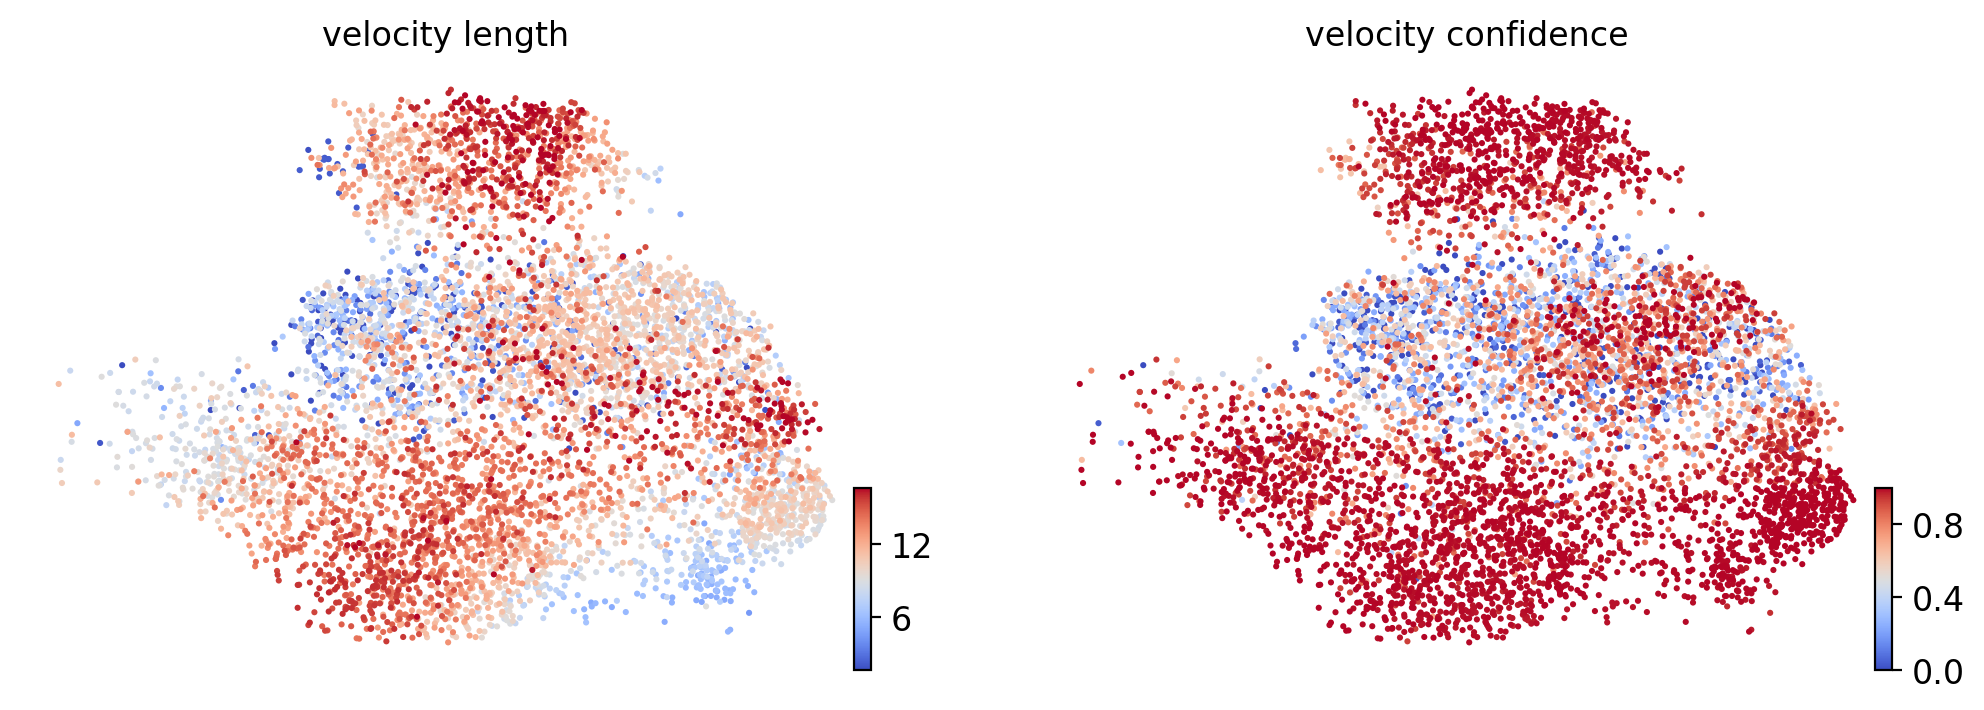

In [24]:
scv.tl.velocity_confidence(adata)
tags = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=tags, cmap='coolwarm', perc=[2, 98])

### Pseudotime analysis

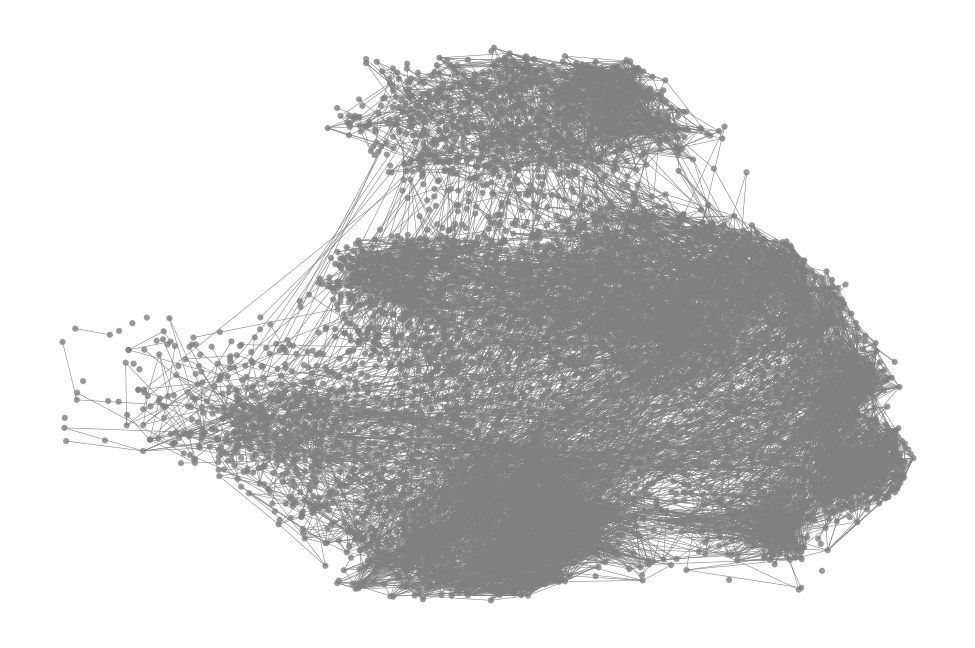

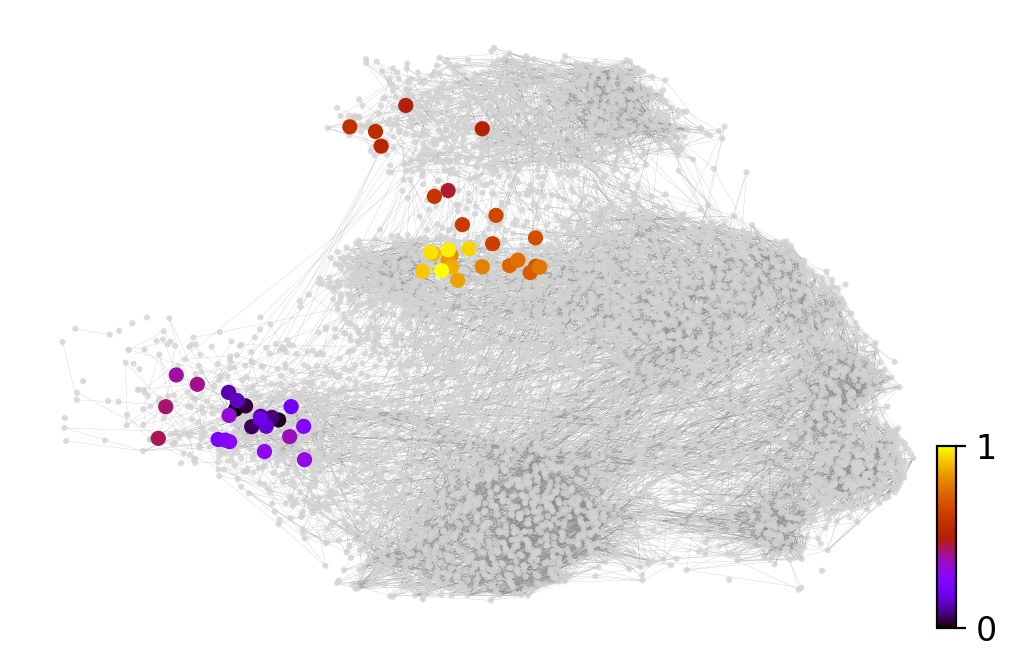

In [26]:
scv.pl.velocity_graph(adata, threshold=.1)
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

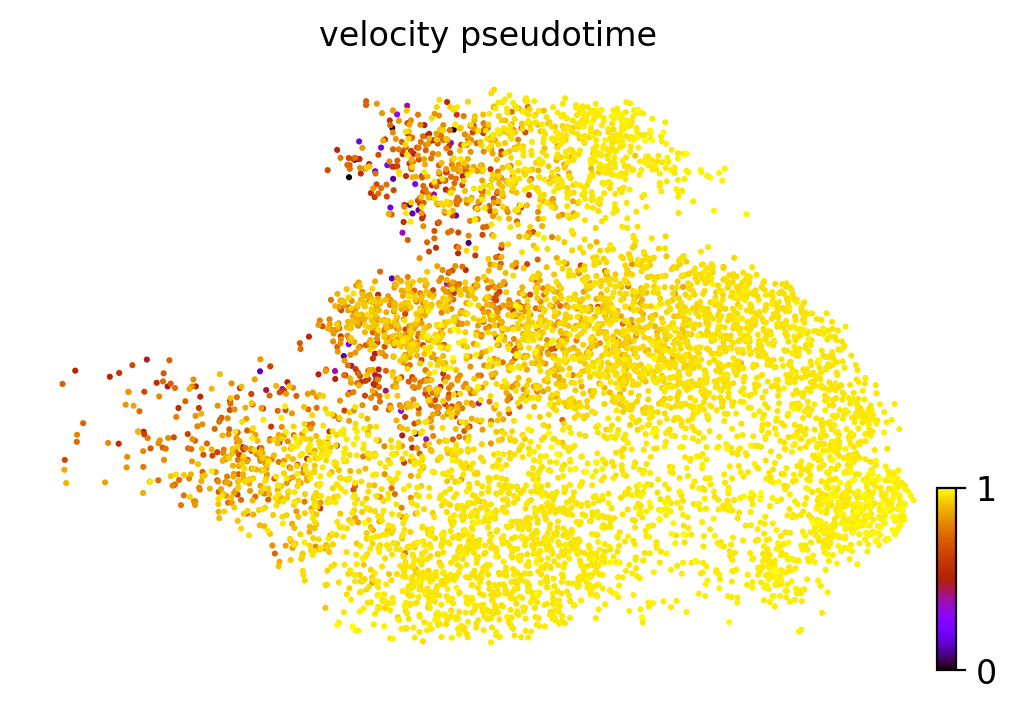

In [27]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

## Trajectory inference

In [32]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='labels')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

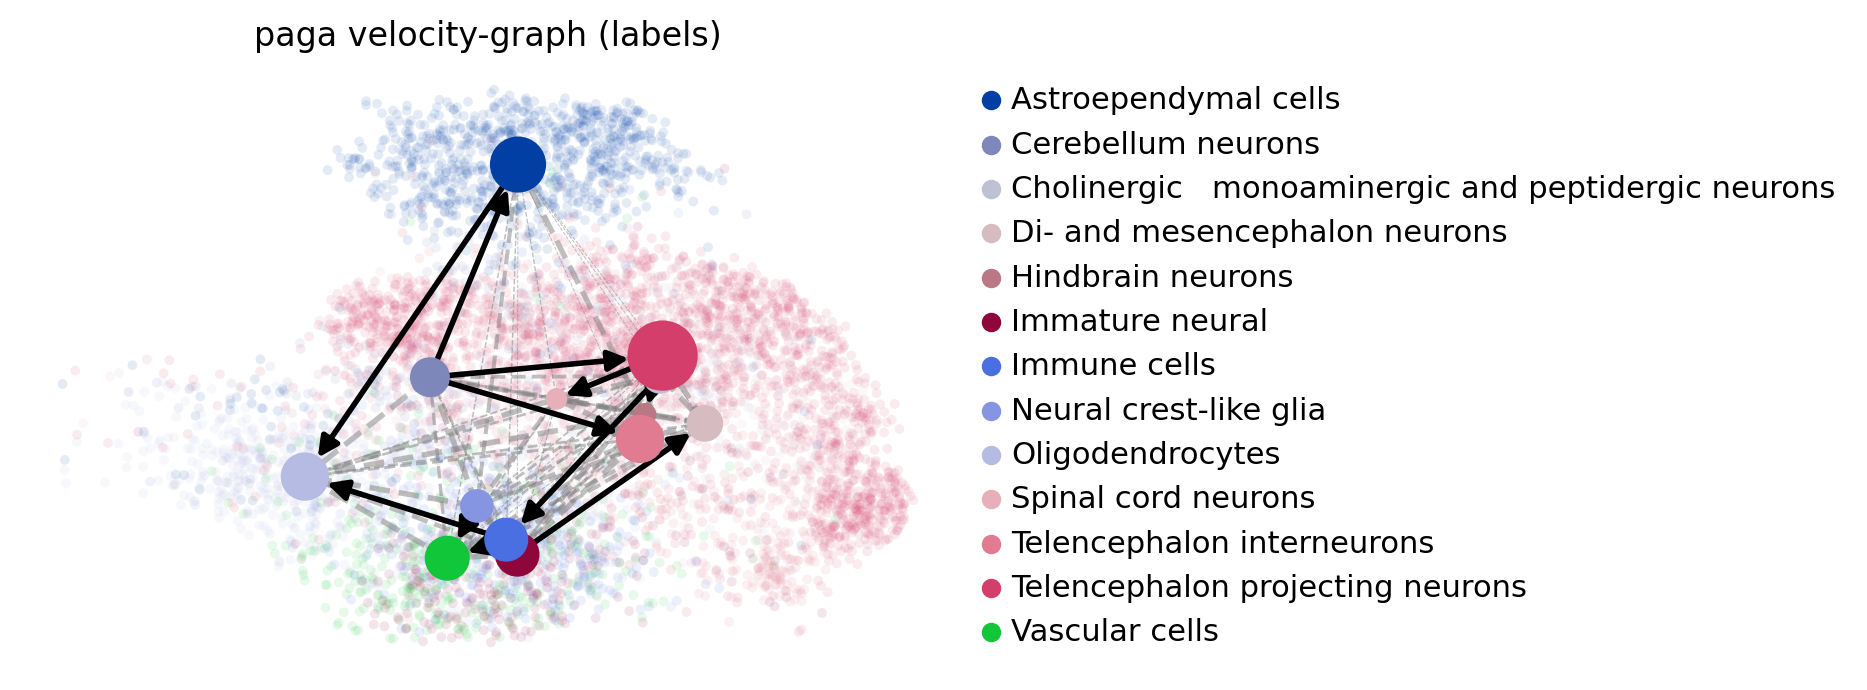

In [33]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

In [36]:
np.sum(adata.var['velocity_genes'])

3